In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [4]:
#Khám phá dữ liệu
df=pd.read_csv("Online Retail.csv")
df.head(10)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
#Nhận thấy có những đơn hàng mà số sản phẩm là âm (đây là những đơn hàng đã bị cancel, InvoiceNo có chữ "c")
df[df['Quantity']<0].head()
#loại bỏ những đơn hàng đã bị hủy
df = df[df['Quantity']>0]
print(df[df['UnitPrice']<=0].head())
df = df[df['UnitPrice']>0]

     InvoiceNo StockCode Description  Quantity       InvoiceDate  UnitPrice  \
622     536414     22139         NaN        56  01/12/2010 11:52        0.0   
1970    536545     21134         NaN         1  01/12/2010 14:32        0.0   
1971    536546     22145         NaN         1  01/12/2010 14:33        0.0   
1972    536547     37509         NaN         1  01/12/2010 14:33        0.0   
1987    536549    85226A         NaN         1  01/12/2010 14:34        0.0   

      CustomerID         Country  
622          NaN  United Kingdom  
1970         NaN  United Kingdom  
1971         NaN  United Kingdom  
1972         NaN  United Kingdom  
1987         NaN  United Kingdom  


In [6]:
# chuyển cột "InvoiceDate" sang định dạng date time
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"],dayfirst=True)
print(df["InvoiceDate"].min(), df["InvoiceDate"].max())

2010-12-01 08:26:00 2011-12-09 12:50:00


In [7]:
#Tạo cột tháng
df["Month"] = df["InvoiceDate"].dt.month
#Lọc dữ liệu từ tháng 3 đến tháng 7
filtered_df = df[(df["Month"] >= 3) & (df["Month"] <= 7)]
print(filtered_df)

       InvoiceNo StockCode                          Description  Quantity  \
105335    545220     21955    DOORMAT UNION JACK GUNS AND ROSES         2   
105336    545220     48194                       DOORMAT HEARTS         2   
105337    545220     22556       PLASTERS IN TIN CIRCUS PARADE         12   
105338    545220     22139     RETROSPOT TEA SET CERAMIC 11 PC          3   
105339    545220    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         4   
...          ...       ...                                  ...       ...   
285416    561903     21900                       KEY FOB , SHED        24   
285417    561903     48187                  DOORMAT NEW ENGLAND         2   
285418    561903     85152      HAND OVER THE CHOCOLATE   SIGN         12   
285419    561903     82600                NO SINGING METAL SIGN        12   
285420    561903     21175          GIN + TONIC DIET METAL SIGN        12   

               InvoiceDate  UnitPrice  CustomerID         Country  Month  


Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     24960
JUMBO BAG RED RETROSPOT               18167
ASSORTED COLOURS SILK FAN             16586
PACK OF 72 RETROSPOT CAKE CASES       15204
WHITE HANGING HEART T-LIGHT HOLDER    14584
PACK OF 60 PINK PAISLEY CAKE CASES    13207
SMALL POPCORN HOLDER                  12684
PARTY BUNTING                         12143
ASSORTED COLOUR BIRD ORNAMENT         11691
PACK OF 12 LONDON TISSUES             11049
Name: Quantity, dtype: int64


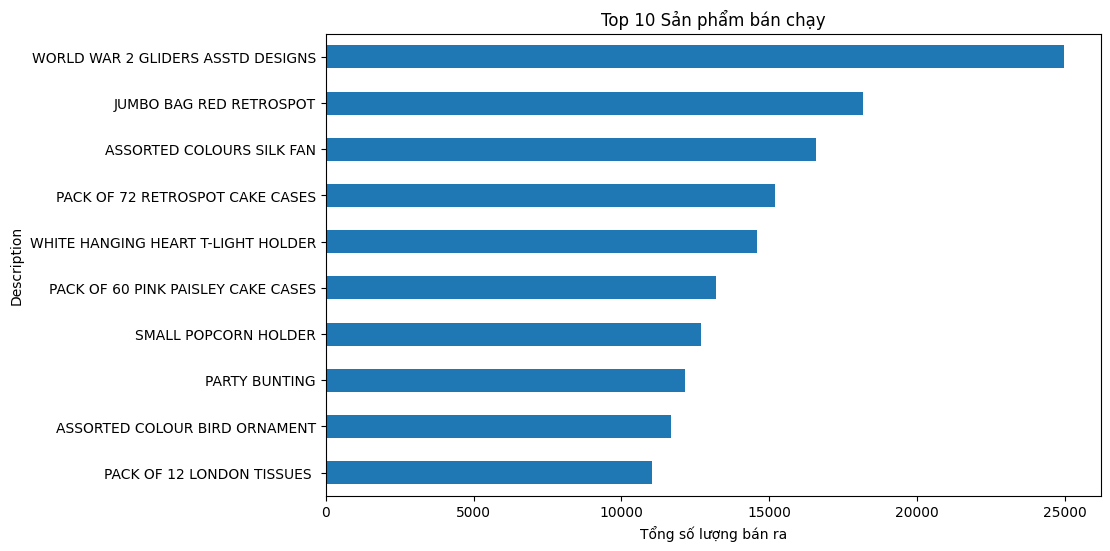

In [8]:
# Câu 1: Khám phá dữ liệu
#Top 10 sản phẩm bán chạy
top_products = filtered_df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
print(top_products)
# Biểu đồ cho thấy số lượng hàng hóa trong top 10 được bán
top_products.head(10).plot(kind='barh', figsize=(10,6), title='Top 10 Sản phẩm bán chạy')
plt.xlabel('Tổng số lượng bán ra')
plt.gca().invert_yaxis()  # đảo trục để sản phẩm bán chạy nhất nằm trên cùng
plt.show()

In [9]:
#Tần suất và giá trị mua hàng trung bình
customer_stats = filtered_df.groupby('CustomerID').agg({
    'InvoiceNo': 'count',  # Tần suất mua hàng (số hóa đơn)
    'Quantity': 'sum',     # Tổng số lượng sản phẩm đã mua
    'UnitPrice': 'mean'    # Giá trị trung bình của sản phẩm
}).rename(columns={
    'InvoiceNo': 'Frequency',
    'Quantity': 'TotalQuantity',
    'UnitPrice': 'AveragePrice'
})

# Hiển thị kết quả
print(customer_stats.head())

            Frequency  TotalQuantity  AveragePrice
CustomerID                                        
12347.0            42            679      2.759762
12348.0             5            269      8.920000
12352.0            23            156     42.379565
12353.0             4             20      6.075000
12354.0            58            530      4.503793


In [10]:
# Câu 2 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
#Tạo ma trận tương quan giữa người dùng và sản phẩm
user_product_matrix = filtered_df.groupby(['CustomerID', 'Description'])['Quantity'].sum().unstack().fillna(0)
user_product_matrix = user_product_matrix.astype(int)
user_product_matrix.to_csv("user_product_matrix", index=True)

In [11]:
# Ma trận tương đồng giữa các khách hàng
user_similarity = cosine_similarity(user_product_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_product_matrix.index, columns=user_product_matrix.index)
# Hệ thống gợi ý dựa trên khách hàng tương tự
def recommend_products(customer_id, user_similarity_df, user_product_matrix, top_n=5):
    # Lấy danh sách người dùng tương tự
    similar_users = user_similarity_df[customer_id].sort_values(ascending=False).index[1:]  # Bỏ chính người dùng đó
    similar_users_weights = user_similarity_df[customer_id].sort_values(ascending=False).iloc[1:]
    
    # Tính điểm gợi ý dựa trên người dùng tương tự
    recommendations = user_product_matrix.loc[similar_users].T.dot(similar_users_weights).sort_values(ascending=False)
    
    # Loại bỏ các sản phẩm mà người dùng đã mua
    already_purchased = user_product_matrix.loc[customer_id]
    recommendations = recommendations[already_purchased == 0]
    
    return recommendations.head(top_n)
# 4. Gợi ý sản phẩm cho một khách hàng cụ thể (ví dụ: CustomerID = 12347.0)
customer_id = 12347.0
recommended_products = recommend_products(customer_id, user_similarity_df, user_product_matrix)
print(f"Gợi ý sản phẩm cho khách hàng {customer_id}:")
print(recommended_products)

Gợi ý sản phẩm cho khách hàng 12347.0:
Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     533.719852
DOUGHNUT LIP GLOSS                    417.449766
PACK OF 72 RETROSPOT CAKE CASES       374.714204
ICE CREAM PEN LIP GLOSS               329.965421
PACK OF 60 PINK PAISLEY CAKE CASES    259.943669
dtype: float64


C:\Users\Admin'\AppData\Local\Temp\ipykernel_13964\567778699.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=recommended_products.values, y=recommended_products.index, palette='viridis')


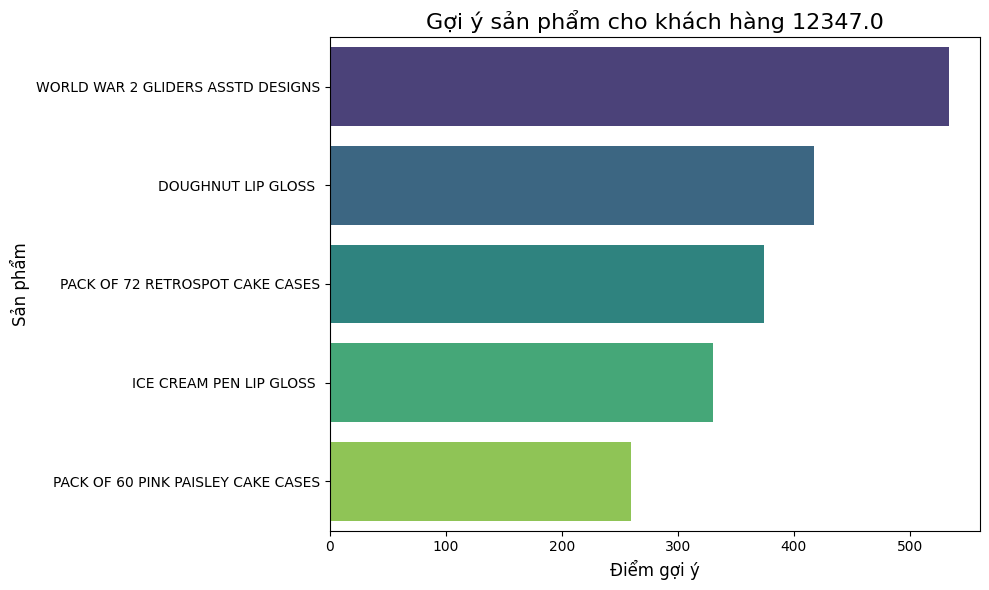

In [12]:
#Trực quan hóa gợi ý cho khách hàng cụ thể
def plot_recommendations(recommended_products, customer_id):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=recommended_products.values, y=recommended_products.index, palette='viridis')
    plt.title(f'Gợi ý sản phẩm cho khách hàng {customer_id}', fontsize=16)
    plt.xlabel('Điểm gợi ý', fontsize=12)
    plt.ylabel('Sản phẩm', fontsize=12)
    plt.tight_layout()
    plt.show()

# Gọi hàm vẽ đồ thị
plot_recommendations(recommended_products, customer_id)

In [17]:
#Hệ thống gợi ý dựa trên sản phẩm tương tự
#Tính độ tương đồng giữa các sản phẩm 
item_similarity = cosine_similarity(user_product_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_product_matrix.columns, columns=user_product_matrix.columns)
#Gợi ý sản phẩm cho một sản phẩm cụ thể
def recommend_similar_items(product_name, item_similarity_df, top_n=5):
    # Lấy danh sách sản phẩm tương tự
    similar_items = item_similarity_df[product_name].sort_values(ascending=False).iloc[1:top_n+1]
    return similar_items

# 4. Gợi ý sản phẩm tương tự cho một sản phẩm cụ thể (ví dụ: "WHITE HANGING HEART T-LIGHT HOLDER")
product_name = "WHITE HANGING HEART T-LIGHT HOLDER"
recommended_items = recommend_similar_items(product_name, item_similarity_df)
print(f"Gợi ý sản phẩm tương tự cho '{product_name}':")
print(recommended_items)

Gợi ý sản phẩm tương tự cho 'WHITE HANGING HEART T-LIGHT HOLDER':
Description
GIN + TONIC DIET METAL SIGN           0.773976
FAIRY CAKE FLANNEL ASSORTED COLOUR    0.728101
TEA TIME TEA TOWELS                   0.728031
DOORMAT FAIRY CAKE                    0.550677
RED HANGING HEART T-LIGHT HOLDER      0.497785
Name: WHITE HANGING HEART T-LIGHT HOLDER, dtype: float64


C:\Users\Admin'\AppData\Local\Temp\ipykernel_13964\1722613031.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=similar_items.values, y=similar_items.index, palette='magma')


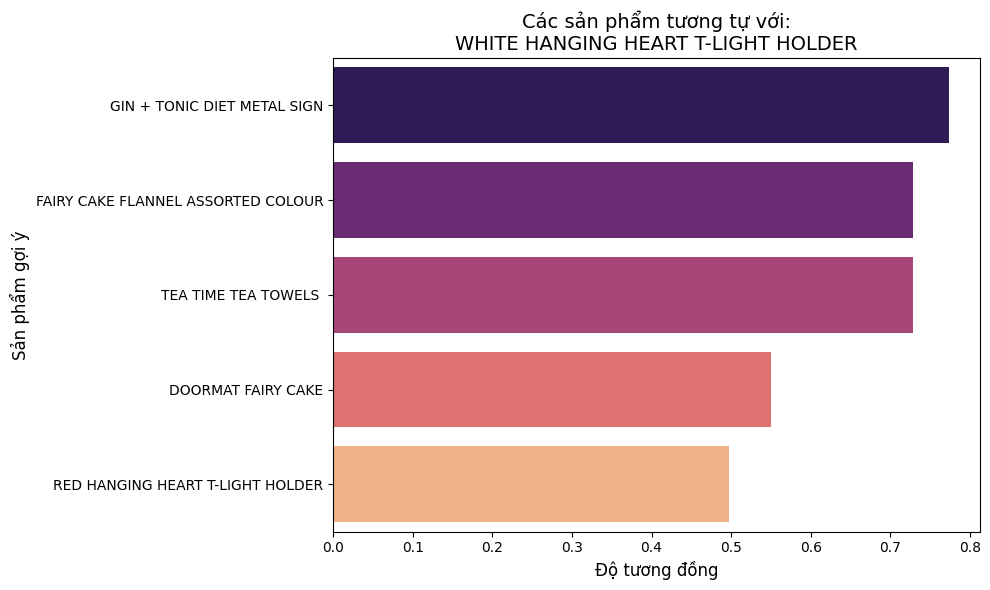

In [18]:
# Trực quan hóa sản phẩm tương tự
def plot_similar_items(product_name, item_similarity_df, top_n=5):
    # Lấy danh sách sản phẩm tương tự
    similar_items = item_similarity_df[product_name].sort_values(ascending=False).iloc[1:top_n+1]

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    sns.barplot(x=similar_items.values, y=similar_items.index, palette='magma')
    plt.title(f"Các sản phẩm tương tự với:\n{product_name}", fontsize=14)
    plt.xlabel("Độ tương đồng", fontsize=12)
    plt.ylabel("Sản phẩm gợi ý", fontsize=12)
    plt.tight_layout()
    plt.show()
plot_similar_items(product_name, item_similarity_df, top_n=5)

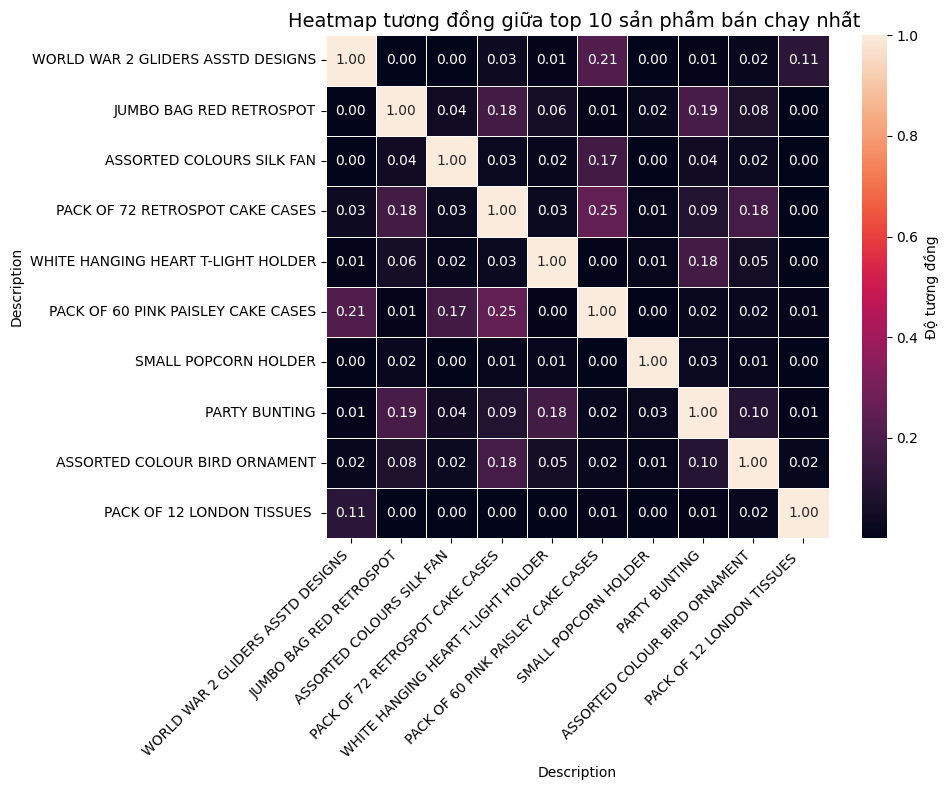

In [ ]:
#Trực quan hóa sản phẩm tương đồng
top_items = filtered_df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).index
top = item_similarity_df.loc[top_items, top_items]

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(top, cmap="rocket", annot=True, fmt=".2f", linewidths=0.5, square=True, cbar_kws={'label': 'Độ tương đồng'})
plt.title("Heatmap tương đồng giữa top 10 sản phẩm bán chạy nhất ", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

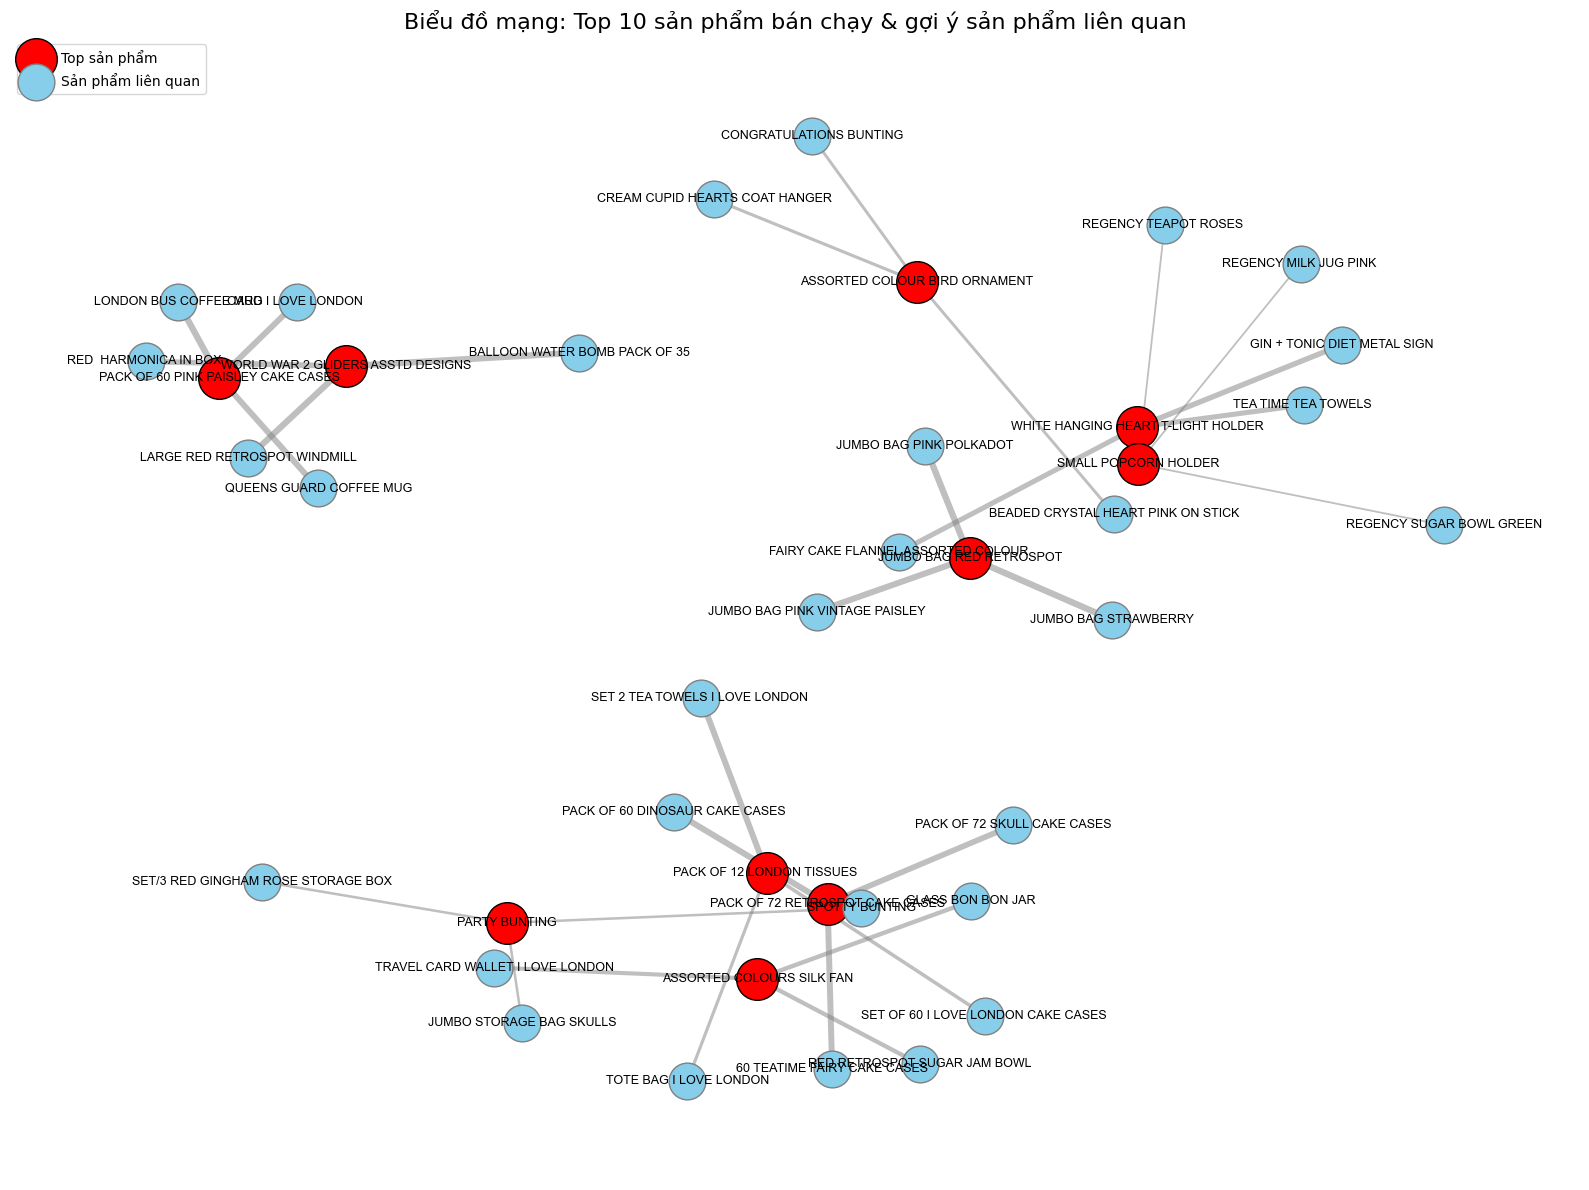

In [ ]:
# Câu 3: Trực quan hóa
# 1. Top sản phẩm
top_items = filtered_df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).index

# 2. Tạo đồ thị
G = nx.Graph()

# 3. Thêm node và edge
for item in top_items:
    G.add_node(item, top=True)
    similar_items = item_similarity_df[item].sort_values(ascending=False).iloc[1:4]  # top 3 sản phẩm tương tự
    for sim_item, sim_score in similar_items.items():
        if sim_score > 0:
            G.add_node(sim_item, top=False)
            G.add_edge(item, sim_item, weight=sim_score)
# 4. Vẽ biểu đồ
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=0.4, seed=42)

# Màu khác nhau cho top item và các sản phẩm gợi ý
top_nodes = [node for node, attr in G.nodes(data=True) if attr.get('top')]
other_nodes = [node for node in G.nodes if node not in top_nodes]

nx.draw_networkx_nodes(G, pos, nodelist=top_nodes, node_size=900, node_color='red', edgecolors='black', label='Top sản phẩm')
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_size=700, node_color='skyblue', edgecolors='gray', label='Sản phẩm liên quan')

edges = G.edges(data=True)
weights = [d['weight']*5 for (_, _, d) in edges]
nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9, font_family="Arial")

plt.title("Biểu đồ mạng: Top 10 sản phẩm bán chạy & gợi ý sản phẩm liên quan", fontsize=16)
plt.axis('off')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
